In [1]:
from PIL import Image, ImageOps
from pathlib import Path

def insert_into_square_canvas(
        in_path: str | Path,
        out_path: str | Path,
        canvas_side: int = 512,
        bg_color: tuple[int, int, int] = (255, 255, 255)  # white
    ) -> None:
    """
    Open `in_path`, letter-box it into a `canvas_side`×`canvas_side` square and
    save to `out_path`.

    The original aspect ratio is preserved; no cropping or stretching occurs.
    """
    img = Image.open(in_path).convert("RGB")

    # --- resize keeping aspect ratio ----------------------------------------
    img.thumbnail((canvas_side, canvas_side), Image.Resampling.LANCZOS)

    # --- create square canvas and centre the image --------------------------
    canvas = Image.new("RGB", (canvas_side, canvas_side), color=bg_color)
    x = (canvas_side - img.width)  // 2
    y = (canvas_side - img.height) // 2
    canvas.paste(img, (x, y))

    # --- save ---------------------------------------------------------------
    canvas.save(out_path, quality=95)



In [6]:
import cv2
import pytesseract
import json
import os

# Set Tesseract executable path (required for Windows users)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to extract word-level bounding boxes and text using Tesseract
def extract_bounding_boxes(image_path, output_json_path, output_boxed_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to load image: {image_path}")
    h, w, _ = image.shape  # Get image dimensions

    # Perform OCR and extract data at the word level
    data = pytesseract.image_to_data(image, lang='sin', output_type=pytesseract.Output.DICT)

    bounding_box_data = []
    n_boxes = len(data["level"])
    for i in range(n_boxes):
        text = data["text"][i].strip()
        # Skip empty text results
        if text != "":
            left = data["left"][i]
            top = data["top"][i]
            width_box = data["width"][i]
            height_box = data["height"][i]
            # Create bounding box as [x_min, y_min, x_max, y_max]
            bbox = [left, top, left + width_box, top + height_box]
            bounding_box_data.append({
                "text": text,
                "bounding_box": bbox,
                "confidence": data["conf"][i]
            })

            # Draw bounding box on the image for visualization
            cv2.rectangle(image, (left, top), (left + width_box, top + height_box), (0, 255, 0), 2)
            cv2.putText(image, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Save bounding box data to a JSON file
    with open(output_json_path, 'w', encoding='utf-8') as json_file:
        json.dump(bounding_box_data, json_file, ensure_ascii=False, indent=4)
    print(f"Bounding boxes saved to: {output_json_path}")

    # Save the image with bounding boxes to a file 
    cv2.imwrite(output_boxed_path, image)
    print(f"Image with bounding boxes saved to: {output_boxed_path}")

# Main function to process images in a folder
def process_images(folder_path, output_folder_json, output_folder_boxed):
    if not os.path.exists(output_folder_json):
        os.makedirs(output_folder_json)
    if not os.path.exists(output_folder_boxed):
        os.makedirs(output_folder_boxed)

    for filename in os.listdir(folder_path):
        # Process common image file formats
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            output_json_path = os.path.join(output_folder_json, f"{os.path.splitext(filename)[0]}.json")
            output_boxed_path = os.path.join(output_folder_boxed, f"{os.path.splitext(filename)[0]}_boxed.jpg")
            
            # Check if the JSON file already exists
            if os.path.exists(output_json_path):
                print(f"Skipping {filename} as JSON file already exists: {output_json_path}")
                continue
            
            extract_bounding_boxes(image_path, output_json_path, output_boxed_path)


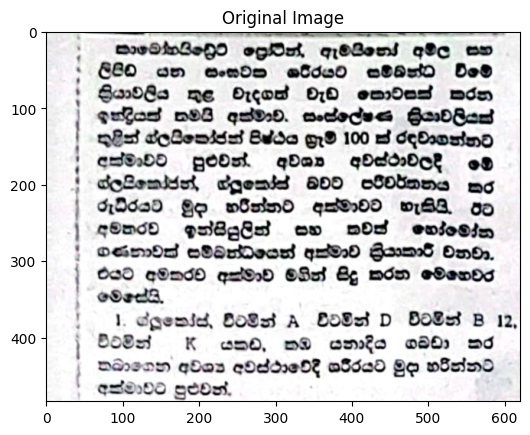

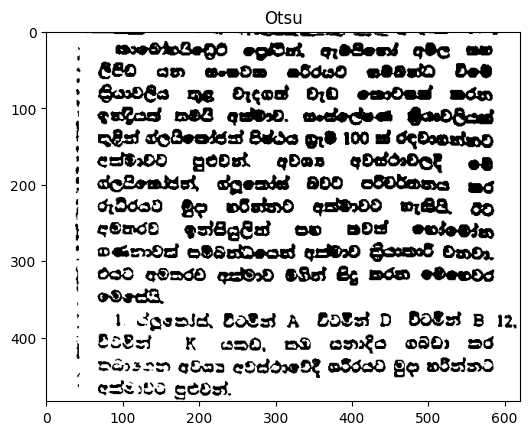

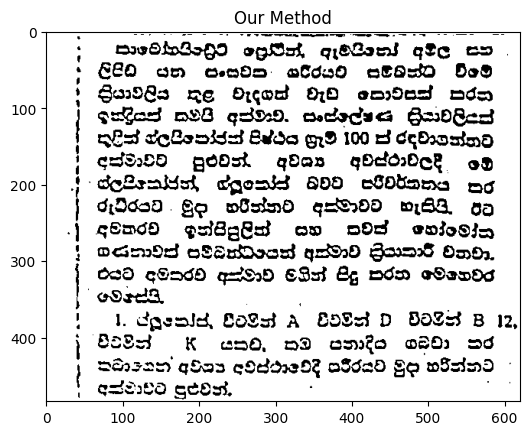

In [10]:
#libraries
import numpy as np
from numpy import linalg
import cv2
from math import sqrt
from math import atan
from math import pow
import matplotlib.pyplot as plt
import glob
from PIL import Image

#reading the image
a = cv2.imread("images_unedited/page_7_1.png")

#showing the original image
plt.title("Original Image")
plt.imshow(a)
plt.show()

#making 3 grayscale images 
b = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
c = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
d = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

#k-value range [0.1-0.5] can be changed depending on image
k=0.1

#r-value can be changed depending on image
r=128

#neighbouring window size can be changed depending on image
window=8

#otsu thresholding
ret2,th= cv2.threshold(b,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#showing otsu result
plt.title("Otsu")
plt.imshow(th,cmap='gray')
plt.show()


h,w=b.shape

th=0
value=[]
threshold=[]
m=0
var=0
std=0
b,c=cv2.integral2(b)

h,w=c.shape

#Sauvola Method using integrl images
for i in range(1, w , 1):
    for j in range(1, h , 1):
        if(j>(h-int(window/2)) and i>(w-int(window/2))):
            m = (b[j, i] + b[j - int(window/2), i - int(window/2)] - b[
                j , i - int(window/2)] - b[j - int(window/2), i]) / (window * window)
            s = (c[j, i] + c[j - int(window/2), i - int(window/2)] - c[
                j, i - int(window/2)] - c[j - int(window/2), i]) / (window * window)
        elif (i > (w - int(window/2)) and j < (h - int(window/2))):
            m = (b[j + int(window/2), i] + b[j - int(window/2), i - int(window/2)] - b[
                j + int(window/2), i - int(window/2)] - b[j - int(window/2), i]) / (window * window)
            s = (c[j + int(window/2), i] + c[j - int(window/2), i - int(window/2)] - c[
                j + int(window/2), i - int(window/2)] - c[j - int(window/2), i]) / (window * window)
        elif(j>(h-int(window/2)) and i<(w-int(window/2))):
            m = ( b[j,i+int(window/2)]+b[j-int(window/2),i-int(window/2)]-b[j,i-int(window/2)]-b[j-int(window/2),i+int(window/2)])/(window*window)
            s = (  c[j,i+int(window/2)]+c[j-int(window/2),i-int(window/2)]-c[j,i-int(window/2)]-c[j-int(window/2),i+int(window/2)])/(window*window)
        elif(j<(h-int(window/2) ) and i<(w-int(window/2))):
            m=(b[j+int(window/2),i+int(window/2)]+b[j-int(window/2),i-int(window/2)]-b[j+int(window/2),i-int(window/2)]-b[j-int(window/2),i+int(window/2)])/(window*window)
            s=(c[j+int(window/2),i+int(window/2)]+c[j-int(window/2),i-int(window/2)]-c[j+int(window/2),i-int(window/2)]-c[j-int(window/2),i+int(window/2)])/(window*window)
        var = ((s)- (pow((m), 2)))/(window*window)
        std = sqrt(abs(var))
        T = m * (1 + (k * ((std / r) - 1)))
        threshold.append(T)




h1,w1=d.shape

#setting pixel values based on computed threshold
for i in range(0, w1, 1):
     for j in range(0, h1, 1):

        if (d[j, i] <= threshold[th]):
             d[j, i] = 0
        else:
             d[j, i] = 255
        th=th+1
        
for i in range(0, int(window/2), 1):
    for j in range(0, h1, 1):
        d[j,i]=255
for i in range(0, w1, 1):
    for j in range(0, int(window/2), 1):
        d[j,i]=255
        
plt.title("Our Method")
plt.imshow(d,cmap='gray')
plt.show()

In [4]:
from pathlib import Path
from PIL import Image
from kraken.lib.binarization import sauvola     



def binarize_and_save(src_path: Path, dst_path: Path) -> None:
    img_pil   = Image.open(src_path).convert("RGB")   # <-- FIX: create PIL.Image
    # img_clean = binarization.nlbin(
    #     img_pil,
    #     threshold=0.55,   # 0.50–0.65  → move *up* if letters look washed out
    #     low=0.2,          # contrast stretch (black point)
    #     high=0.50,        # … (white point)
    #     perc=97,          # percent of brightest pixels considered background
    #     border=0          # >0 cuts dark page edges; start with 0
    # )
    img_clean = binarization.sauvola(
    img_pil,            # PIL.Image
    ws=25,          # window size, 15–35 typical
    k=0.2           # higher = lighter result
)
    img_clean.save(dst_path, format="PNG", optimize=True)
    print(f"✔ {dst_path.name} saved")



ModuleNotFoundError: No module named 'kraken.lib.binarization'

In [21]:
from glob import glob
import os

unedited_img_dir =  r"D:\python\data\images_unedited" 
binarized_img_dir =  r"D:\python\data\binarized_images" 
canvased_img_dir =  r"D:\python\data\images" 
os.makedirs(canvased_img_dir, exist_ok=True)

for fp in glob(f"{unedited_img_dir}/*.*"):
    fp_path = Path(fp)  # Convert string to Path object
    out_fp = Path(binarized_img_dir) / f"{fp_path.stem}.png"  # Ensure out_fp is a Path object
    binarize_and_save(fp_path, out_fp)  # Pass Path objects directly to the function


for fp in glob(f"{binarized_img_dir}/*.*"):
    fp_path = Path(fp)  # Convert string to Path object
    out_fp = os.path.join(canvased_img_dir, fp_path.stem + ".png")
    insert_into_square_canvas(fp, out_fp)

input_folder = r"D:\python\data\images"   # Replace with your folder containing images
output_json = r"D:\python\data\json"     # Replace with your output folder
output_boxed = r"D:\python\data\boxed"     # Replace with your output folder
process_images(input_folder, output_json, output_boxed)

AttributeError: module 'kraken.binarization' has no attribute 'sauvola'

In [32]:
import os
import json
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# ------------------------------
# 1. Define the Character Set and Helper Functions
# ------------------------------

# In this example, we use a simple character set: lowercase letters and space.
# For CTC loss, index 0 is reserved as the blank token.
charset = ['අ', 'ආ', 'ඇ', 'ඈ', 'ඉ', 'ඊ', 'උ', 'ඌ', 'එ', 'ඒ', 'ඔ', 'ඕ', 'ඓ', 'ඖ',
  'ක', 'කා', 'කැ', 'කෑ', 'කි', 'කී', 'කු', 'කූ', 'කෙ', 'කේ', 'කො', 'කෝ', 'කෛ', 'කෞ',
  'ඛ', 'ඛා', 'ඛැ', 'ඛෑ', 'ඛි', 'ඛී', 'ඛු', 'ඛූ', 'ඛෙ', 'ඛේ', 'ඛො', 'ඛෝ', 'ඛෛ', 'ඛෞ',
  'ග', 'ගා', 'ගැ', 'ගෑ', 'ගි', 'ගී', 'ගු', 'ගූ', 'ගෙ', 'ගේ', 'ගො', 'ගෝ', 'ගෛ', 'ගෞ',
  'ච', 'චා', 'චැ', 'චෑ', 'චි', 'චී', 'චු', 'චූ', 'චෙ', 'චේ', 'චො', 'චෝ', 'චෛ', 'චෞ',
  'ජ', 'ජා', 'ජැ', 'ජෑ', 'ජි', 'ජී', 'ජු', 'ජූ', 'ජෙ', 'ජේ', 'ජො', 'ජෝ', 'ජෛ', 'ජෞ',
  'ට', 'ටා', 'ටැ', 'ටෑ', 'ටි', 'ටී', 'ටු', 'ටූ', 'ටෙ', 'ටේ', 'ටො', 'ටෝ', 'ටෛ', 'ටෞ',
  'ඩ', 'ඩා', 'ඩැ', 'ඩෑ', 'ඩි', 'ඩී', 'ඩු', 'ඩූ', 'ඩෙ', 'ඩේ', 'ඩො', 'ඩෝ', 'ඩෛ', 'ඩෞ',
  'ණ', 'ණා', 'ණැ', 'ණෑ', 'ණි', 'ණී', 'ණු', 'ණූ', 'ණෙ', 'ණේ', 'ණො', 'ණෝ', 'ණෛ', 'ණෞ',
  'ත', 'තා', 'තැ', 'තෑ', 'ති', 'තී', 'තු', 'තූ', 'තෙ', 'තේ', 'තො', 'තෝ', 'තෛ', 'තෞ',
  'ද', 'දා', 'දැ', 'දෑ', 'දි', 'දී', 'දු', 'දූ', 'දෙ', 'දේ', 'දො', 'දෝ', 'දෛ', 'දෞ',
  'න', 'නා', 'නැ', 'නෑ', 'නි', 'නී', 'නු', 'නූ', 'නෙ', 'නේ', 'නො', 'නෝ', 'නෛ', 'නෞ',
  'ප', 'පා', 'පැ', 'පෑ', 'පි', 'පී', 'පු', 'පූ', 'පෙ', 'පේ', 'පො', 'පෝ', 'පෛ', 'පෞ',
  'බ', 'බා', 'බැ', 'බෑ', 'බි', 'බී', 'බු', 'බූ', 'බෙ', 'බේ', 'බො', 'බෝ', 'බෛ', 'බෞ',
  'ම', 'මා', 'මැ', 'මෑ', 'මි', 'මී', 'මු', 'මූ', 'මෙ', 'මේ', 'මො', 'මෝ', 'මෛ', 'මෞ',
  'ය', 'යා', 'යැ', 'යෑ', 'යි', 'යී', 'යු', 'යූ', 'යෙ', 'යේ', 'යො', 'යෝ', 'යෛ', 'යෞ',
  'ර', 'රා', 'රැ', 'රෑ', 'රි', 'රී', 'රු', 'රූ', 'රෙ', 'රේ', 'රො', 'රෝ', 'රෛ', 'රෞ',
  'ල', 'ලා', 'ලැ', 'ලෑ', 'ලි', 'ලී', 'ලු', 'ලූ', 'ලෙ', 'ලේ', 'ලො', 'ලෝ', 'ලෛ', 'ලෞ',
  'ව', 'වා', 'වැ', 'වෑ', 'වි', 'වී', 'වු', 'වූ', 'වෙ', 'වේ', 'වො', 'වෝ', 'වෛ', 'වෞ',
  'ශ', 'ශා', 'ශැ', 'ශෑ', 'ශි', 'ශී', 'ශු', 'ශූ', 'ශෙ', 'ශේ', 'ශො', 'ශෝ', 'ශෛ', 'ශෞ',
  'ෂ', 'ෂා', 'ෂැ', 'ෂෑ', 'ෂි', 'ෂී', 'ෂු', 'ෂූ', 'ෂෙ', 'ෂේ', 'ෂො', 'ෂෝ', 'ෂෛ', 'ෂෞ',
  'ස', 'සා', 'සැ', 'සෑ', 'සි', 'සී', 'සු', 'සූ', 'සෙ', 'සේ', 'සො', 'සෝ', 'සෛ', 'සෞ',
  'හ', 'හා', 'හැ', 'හෑ', 'හි', 'හී', 'හු', 'හූ', 'හෙ', 'හේ', 'හො', 'හෝ', 'හෛ', 'හෞ',
  'ළ', 'ළා', 'ළැ', 'ළෑ', 'ළි', 'ළී', 'ළු', 'ළූ', 'ළෙ', 'ළේ', 'ළො', 'ළෝ', 'ළෛ', 'ළෞ','ක්‍ර', 'ක්‍රි', 'ක්‍රී', 'ක්‍රා', 'ක්‍රැ', 'ක්‍රෑ',
  'ප්‍ර', 'ප්‍රි', 'ප්‍රී', 'ප්‍රා',
  'ද්‍ර', 'ද්‍රි', 'ද්‍රී', 'ද්‍රෝ',
  'ත්‍ර', 'ත්‍රි', 'ත්‍රී', 'ත්‍රැ', 'ත්‍රෑ',
  'ශ්‍ර', 'ශ්‍රි', 'ශ්‍රී', 'ශ්‍රැ', 'ශ්‍රෑ'
            
]
char2idx = {c: i + 1 for i, c in enumerate(charset)}  # map characters to indices (starting at 1)
num_classes = len(charset) + 1  # +1 for CTC blank

In [21]:
def text_to_sequence(text):
    """Convert a text string to a list of indices based on the charset."""
    return [char2idx[c] for c in text if c in char2idx]

In [22]:
# ------------------------------
# 2. Define a Custom Dataset for Multi-Word OCR
# ------------------------------

class OCRMultiWordDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        """
        images_dir: Directory of image files.
        annotations_dir: Directory of JSON annotation files – one per image.
            Each JSON file is expected to have the following structure:
            [
                {
                    "text": "word1",
                    "bounding_box": [x_min, y_min, x_max, y_max],
                    "confidence": confidence_value
                },
                ...
            ]
        transform: Optional transform to be applied to a PIL image or NumPy array.
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        try:
            img_name = self.image_files[idx]
            img_path = os.path.join(self.images_dir, img_name)
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Failed to load image at {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

            # Construct the annotation path with the "_boxed" suffix
            annotation_name = f"{os.path.splitext(img_name)[0]}.json"
            annotation_path = os.path.join(self.annotations_dir, annotation_name)

            # Check if the annotation file exists
            if not os.path.exists(annotation_path):
                raise FileNotFoundError(f"Annotation file not found: {annotation_path}")

            # Specify UTF-8 encoding when opening the JSON file
            with open(annotation_path, 'r', encoding='utf-8') as f:
                annotations = json.load(f)

            # Debug: Print the loaded JSON file path and its content
            print(f"Loaded JSON file: {annotation_path}")
            print(f"Annotations: {annotations}")

            # Process annotations (as in your existing code)
            boxes = []
            text_targets = []
            target_lengths = []

            _, H, W = image.shape
            for ann in annotations:
                bbox = ann["bounding_box"]
                bbox_norm = [bbox[0] / W, bbox[1] / H, bbox[2] / W, bbox[3] / H]
                boxes.append(bbox_norm)
                text = ann["text"].strip().lower()
                seq = text_to_sequence(text)
                text_targets.append(torch.tensor(seq, dtype=torch.long))
                target_lengths.append(len(seq))

            boxes = torch.tensor(boxes, dtype=torch.float32)
            return image, boxes, text_targets, target_lengths
        except Exception as e:
            print(f"Error processing file {img_name}: {e}")
            return None

In [23]:
# ------------------------------
# 3. Create a Custom Collate Function
# ------------------------------

def ocr_collate_fn(batch):
    """
    This collate function takes a list of samples from OCRMultiWordDataset.
    Each sample: (image, boxes, text_targets, target_lengths)
    It stacks the images into a batch tensor and keeps the others in lists.
    """
    images = [item[0] for item in batch]
    images = torch.stack(images, dim=0)
    boxes_list = [item[1] for item in batch]          # List of tensors (sizes vary per image)
    text_targets_list = [item[2] for item in batch]     # List of lists (each inner list may have varying number)
    target_lengths_list = [item[3] for item in batch]   # List of lists of ints

    return images, boxes_list, text_targets_list, target_lengths_list


In [25]:
# ------------------------------
# 4. Define the Recognition Network
# ------------------------------

class TextRecognizer(nn.Module):
    def __init__(self, num_classes):
        super(TextRecognizer, self).__init__()
        # A simple CNN backbone.
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),   # (B, 64, H, W)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # (B, 64, H/2, W/2)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B, 128, H/2, W/2)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                            # (B, 128, H/4, W/4)
        )
        # After CNN, average pool over the height dimension to convert feature map into a sequence.
        # In our example, we assume the crop has been resized to (32, 128) (height, width).
        # After 2 pooling layers: height becomes 32/4 = 8, width becomes 128/4 = 32.
        self.lstm = nn.LSTM(128, 256, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256 * 2, num_classes)  # bidirectional LSTM outputs hidden_dim*2 features

    def forward(self, x):
        """
        x: Tensor of shape (B, 3, 32, 128)
        Returns:
            Outputs of shape (T, B, num_classes), where T is the sequence length (here, 32).
        """
        features = self.cnn(x)  # (B, 128, 8, 32)
        # Average over the height dimension to form a sequence (time dimension = width)
        features = torch.mean(features, dim=2)  # (B, 128, 32)
        features = features.permute(0, 2, 1)      # (B, 32, 128)
        outputs, _ = self.lstm(features)         # (B, 32, 512)
        outputs = self.fc(outputs)               # (B, 32, num_classes)
        outputs = outputs.permute(1, 0, 2)         # (T, B, num_classes) for CTC loss
        return outputs


In [26]:
# ------------------------------
# 5. Define the End‑to‑End OCR Model for Multi‑Word Images
# ------------------------------

class EndToEndOCRMulti(nn.Module):
    def __init__(self, num_classes):
        super(EndToEndOCRMulti, self).__init__()
        # For this demo, we focus on recognition.
        # In a full system, a multi‑object detection branch would also be included.
        self.recognizer = TextRecognizer(num_classes)

    def forward(self, images, gt_boxes_list):
        """
        images: Tensor of shape (B, 3, H, W)
        gt_boxes_list: List of length B; each element is a tensor of shape (N, 4) where N is the number
                       of text boxes in that image (normalized to [0,1]).
        Returns: Recognition logits of shape (T, total_boxes, num_classes)
        """
        crops = []
        batch_size = images.size(0)
        for i in range(batch_size):
            image = images[i:i+1]  # shape: (1, 3, H, W)
            _, H, W = image.shape[1:]
            # Loop over all bounding boxes for the current image.
            for box in gt_boxes_list[i]:
                # box = [x_min, y_min, x_max, y_max] in normalized coordinates.
                x_min = int(box[0].item() * W)
                y_min = int(box[1].item() * H)
                x_max = int(box[2].item() * W)
                y_max = int(box[3].item() * H)
                x_min = max(x_min, 0)
                y_min = max(y_min, 0)
                x_max = min(x_max, W)
                y_max = min(y_max, H)
                # Crop the word region.
                crop = image[:, :, y_min:y_max, x_min:x_max]
                # Resize the crop to fixed size expected by the recognizer (e.g., 32x128).
                crop = F.interpolate(crop, size=(32, 128), mode='bilinear', align_corners=False)
                crops.append(crop)
        if len(crops) == 0:
            # In case no boxes are found, return an empty tensor.
            return None
        # Concatenate all cropped word regions into one batch.
        crops = torch.cat(crops, dim=0)  # shape: (total_boxes, 3, 32, 128)
        recog_logits = self.recognizer(crops)  # shape: (T, total_boxes, num_classes)
        return recog_logits

In [28]:
if __name__ == "__main__":
    # Define transforms – here just converting to tensor.
    transform = transforms.Compose([
    transforms.Resize((512, 256)),  # (height, width) - adjust as needed
    transforms.ToTensor()
])

    # Update these paths to point to your dataset directories.
    images_dir = input_folder
    annotations_dir = output_folder

    dataset = OCRMultiWordDataset(images_dir, annotations_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=ocr_collate_fn, num_workers=0)  # Set num_workers=0 for debugging

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EndToEndOCRMulti(num_classes).to(device)

    ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 10

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch in dataloader:
            if batch is None:
                continue  # Skip problematic batches
            images, boxes_list, text_targets_list, target_lengths_list = batch
            images = images.to(device)

            recog_logits = model(images, boxes_list)
            if recog_logits is None or recog_logits.size(1) == 0:
                print("Skipping batch due to empty recog_logits")
                continue

            T, total_words, _ = recog_logits.size()
            input_lengths = torch.full(size=(total_words,), fill_value=T, dtype=torch.long).to(device)

            targets = []
            all_target_lengths = []
            for text_list, length_list in zip(text_targets_list, target_lengths_list):
                for seq, length in zip(text_list, length_list):
                    targets.append(seq)
                    all_target_lengths.append(length)

            if len(targets) == 0:
                print("Skipping batch due to empty targets")
                continue

            targets_cat = torch.cat(targets).to(device)
            target_lengths = torch.tensor(all_target_lengths, dtype=torch.long).to(device)

            if targets_cat.size(0) != target_lengths.sum():
                print("Mismatch between targets_cat and target_lengths. Skipping batch.")
                continue

            optimizer.zero_grad()
            try:
                loss_recog = ctc_loss_fn(recog_logits, targets_cat, input_lengths, target_lengths)
                loss_recog.backward()
                optimizer.step()
                total_loss += loss_recog.item()
            except Exception as e:
                print(f"Error during loss computation: {e}")
                continue

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Recognition Loss: {avg_loss:.4f}")

Starting training...
Error processing file page_1_3_boxed.png: Unexpected type <class 'numpy.ndarray'>
Error processing file page_1_4.png: Unexpected type <class 'numpy.ndarray'>


TypeError: 'NoneType' object is not subscriptable

In [15]:
def sequence_to_text(seq):
    # seq: list or numpy array of indices
    # skips blanks (0) and out-of-range indices
    return ''.join([charset[idx] for idx in seq if idx != 0 and idx < len(charset)])

In [16]:
def greedy_decode(logits):
    # logits: (T, N, C) where T = time, N = batch*words, C = num_classes
    # Returns: list of lists of predicted indices (one per word)
    probs = logits.softmax(2)
    max_probs, max_indices = probs.max(2)  # (T, N)
    max_indices = max_indices.cpu().numpy().T  # (N, T)
    decoded = []
    for seq in max_indices:
        # Collapse repeats and remove blanks (assume blank=0)
        prev = -1
        out = []
        for idx in seq:
            if idx != prev and idx != 0:
                out.append(idx)
            prev = idx
        decoded.append(out)
    return decoded

def compute_accuracy(model, dataloader, device):
    model.eval()
    total_words = 0
    correct_words = 0
    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            images, boxes_list, text_targets_list, target_lengths_list = batch
            images = images.to(device)
            recog_logits = model(images, boxes_list)
            if recog_logits is None or recog_logits.size(1) == 0:
                continue
            decoded = greedy_decode(recog_logits)
            # Flatten ground truth targets
            gt_texts = []
            for text_list in text_targets_list:
                for seq in text_list:
                    gt_texts.append(sequence_to_text(seq.cpu().numpy()))
            # Convert predictions to text
            pred_texts = [sequence_to_text(seq) for seq in decoded]
            # Compare predictions and ground truth
            for gt, pred in zip(gt_texts, pred_texts):
                if gt == pred:
                    correct_words += 1
                total_words += 1
    acc = correct_words / total_words if total_words > 0 else 0
    print(f"Word-level accuracy: {acc:.4f} ({correct_words}/{total_words})")
    return acc

# Example usage after training:
compute_accuracy(model, dataloader, device)

Loaded JSON file: D:\python\data\boxed\image_00cd9460-a0de-4c24-b8b4-66115a729e7d.json
Annotations: [{'text': 'මේ', 'bounding_box': [10, 12, 35, 32], 'confidence': 92}, {'text': 'අන්ඩුව', 'bounding_box': [50, 11, 106, 36], 'confidence': 91}, {'text': 'පත්\u200c', 'bounding_box': [122, 11, 151, 32], 'confidence': 96}, {'text': 'කිරීම', 'bounding_box': [167, 12, 210, 32], 'confidence': 96}, {'text': 'ගෑන', 'bounding_box': [226, 18, 263, 35], 'confidence': 96}, {'text': 'මම', 'bounding_box': [279, 14, 307, 32], 'confidence': 95}, {'text': 'නම්\u200c', 'bounding_box': [322, 12, 352, 32], 'confidence': 96}, {'text': 'දුක්\u200c', 'bounding_box': [368, 11, 395, 36], 'confidence': 96}, {'text': 'වෙන්නේ', 'bounding_box': [411, 11, 479, 32], 'confidence': 96}, {'text': 'නෑ.', 'bounding_box': [10, 54, 31, 71], 'confidence': 96}, {'text': 'ඒකට', 'bounding_box': [51, 47, 95, 68], 'confidence': 96}, {'text': 'හේතුව', 'bounding_box': [110, 47, 166, 72], 'confidence': 94}, {'text': 'මෙන්න', 'bounding

0.4753521126760563